# Introduction to Conditional Density Estimation

<br/>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [59]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi, log
from torch.utils import data
import numpy as np
from torch import tensor
torch.manual_seed(0)
from torch.distributions import Normal


## What's going on here? An intro to density estimation.

In [3]:
mean = 1.0
std = 0.4

normal_dist = Normal(mean, std)
samples = normal_dist.sample((50,))

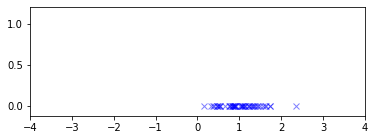

In [4]:
fig = plt.figure(figsize=(6, 2))
plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none')
_ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])
# plt.savefig("samples.png", dpi=200)

In [5]:
x = torch.linspace(-4, 4, 100)
probs = torch.exp(normal_dist.log_prob(x))

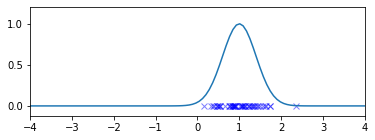

In [6]:
fig = plt.figure(figsize=(6, 2))
plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none')
plt.plot(x, probs)
_ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])
# plt.savefig("fitted_samples.png", dpi=200)

Let's say we have some datapoints in 1D

Our goal is to estimate the underlying distribution of these samples

# Exercise 1: fitting a Gaussian to data with maximum likelihood

### Learning mean and standard deviation

In [7]:
dataset = data.TensorDataset(samples)
train_loader = data.DataLoader(samples, batch_size=10)

mean = torch.nn.Parameter(torch.zeros(1))
log_std = torch.nn.Parameter(torch.zeros(1))

opt = optim.Adam([mean, log_std], lr=0.005)

for e in range(500):
    for sample_batch in samples:
        opt.zero_grad()
        std = torch.exp(log_std)
        prob_Gauss = 1/torch.sqrt(2*pi*std**2) * torch.exp(-.5/std**2*(sample_batch-mean)**2)
        loss = -torch.log(prob_Gauss).sum()
        loss.backward() 
        opt.step()

In [8]:
print("Learned mean: ", mean.item(), ", learned standard deviation: ", torch.exp(log_std).item())

Learned mean:  1.0295751094818115 , learned standard deviation:  0.4328019917011261


### Questions to think about

1) Why do we parameterize the logarithm of the standard deviation instead of the standard deviation itself?  
2) We are evaluating the probability in batches of samples. Does this also work for single parameters (i.e. non-batched)?

# Conditional density estimation
The goal is to estimate parameters of a conditional distribution:
<img src="./Gaussian_estimation.png" alt="drawing" width="300"/>  
We now assume a **conditional** Gaussian distribution:  
$L = -\sum_i \log q(t_i|x_i) = -\sum_i \log N(t_i; \mu(x_i), \sigma(x_i))$  

### Example problem:
Generate data from $x = t + 0.3 \sin(2 \pi t) + \epsilon$

In [42]:
# generate data
n = 4000
d = 1
t = 1

In [43]:
theta = torch.rand((n, d))

noise = torch.rand((n, d)) * 0.2 - 0.1 # uniform in [-0.1, 0.1]
x = theta + 0.3*torch.sin(2*pi*theta) + noise

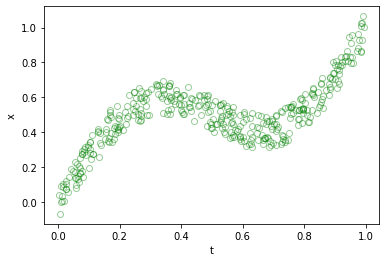

In [44]:
# Data t_train and x_train
fig = plt.figure(figsize=(6, 4))
plt.plot(theta[:400], x[:400], 'go', alpha=0.4, markerfacecolor='none')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

# Exercise 2

### Learning mean and standard deviation conditional on inputs

In [45]:
dataset = data.TensorDataset(theta, x)
train_loader = data.DataLoader(
    dataset, batch_size=20)

net = nn.Sequential(
    nn.Linear(1, 20), nn.ReLU(),
    nn.Linear(20, 20), nn.ReLU(),
    nn.Linear(20, 2))

opt = optim.Adam(net.parameters(), lr=0.01)
for e in range(100):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        nn_output = net(theta_batch)
        mean = nn_output[:, 0].unsqueeze(1)
        std = torch.exp(nn_output[:,1]).unsqueeze(1)
        prob_Gauss = 1/torch.sqrt(2*pi*std**2) * torch.exp(-.5/std**2*(mean-x_batch)**2)
        loss = -torch.log(prob_Gauss).sum()
        loss.backward()
        opt.step()

We now have a neural network which outputs the parameters of a probability density distribution given inputs.
In this case, it was a Gaussian distribution of which we learned the mean and standard deviation. To evaluate the result, we can look at samples from the returned distribution.

### Inspect the distribution for t = 0.2

In [46]:
theta_test = tensor([0.2])
nn_output = net(theta_test)
mean = nn_output[0].detach().numpy()
std = torch.exp(nn_output[1]).detach().numpy()

/home/michael/anaconda3/envs/workshop/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/michael/anaconda3/envs/workshop/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


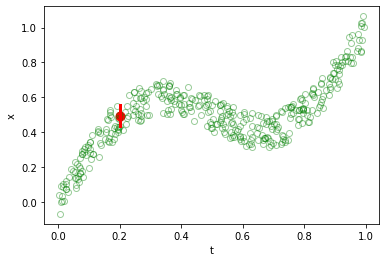

In [47]:
# Data t_train and x_train
fig = plt.figure(figsize=(6, 4))
plt.plot(theta[:400], x[:400], 'go', alpha=0.4, markerfacecolor='none')
plt.scatter(theta_test, mean, c="r", s=80)
plt.plot([theta_test, theta_test], [mean-std, mean+std], c="r", linewidth=3)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

### Alternative evaluation: for every $t$, sample from the Gaussian

In [48]:
samples = []
theta_test = torch.linspace(0.0, 1.0, 500).unsqueeze(1)

for single_theta in theta_test:
    network_outs = net(single_theta.unsqueeze(1))
    m = network_outs[:,0]
    s = torch.exp(network_outs[:,1])
    conditional_distribution = Normal(m, s)
    sample = conditional_distribution.sample((1,))
    
    samples.append(sample)
samples = torch.cat(samples).data

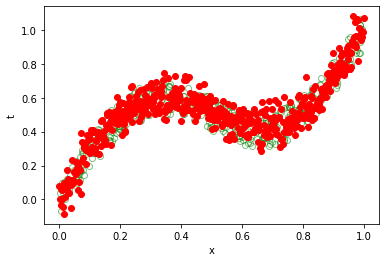

In [49]:
# plot
fig = plt.figure(figsize=(6, 4))
plt.plot(theta[:400], x[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(theta_test, samples.squeeze().detach(), 'ro', linewidth=3.0)
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data_prob_std_fit.png", dpi=200)
plt.show()

# But what if the conditional distribution is not Gaussian?

### Example: Predict the inverse
Again, generate data from $x = t + 0.3 \sin(2 \pi t) + \epsilon$. But now, predict $t$ from $x$.

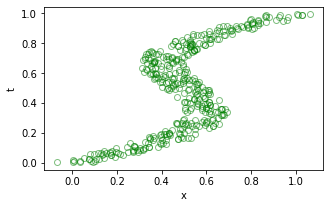

In [50]:
fig = plt.figure(figsize=(5, 3))
plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data1.png", dpi=200)
plt.show()

In [51]:
_ = torch.manual_seed(0)

In [52]:
dataset = data.TensorDataset(x, theta)
train_loader = data.DataLoader(
    dataset, batch_size=20)

net = nn.Sequential(
    nn.Linear(1, 20), nn.ReLU(),
    nn.Linear(20, 20), nn.ReLU(),
    nn.Linear(20, 2))

opt = optim.Adam(net.parameters(), lr=0.01)
for e in range(100):
    for x_batch, theta_batch in train_loader:
        opt.zero_grad()
        nn_output = net(x_batch)
        mean = nn_output[:, 0].unsqueeze(1)
        std = torch.exp(nn_output[:,1]).unsqueeze(1)
        prob_Gauss = 1/torch.sqrt(2*pi*std**2) * torch.exp(-.5/std**2*(mean-theta_batch)**2)
        loss = -torch.log(prob_Gauss).sum()
        loss.backward()
        opt.step()

In [53]:
samples = []
x_test = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)

for single_x in x_test:
    network_outs = net(single_x.unsqueeze(1))
    mean = network_outs[:,0]
    std = torch.exp(network_outs[:,1])
    conditional_distribution = Normal(mean, std)
    sample = conditional_distribution.sample((1,))
    
    samples.append(sample)
samples = torch.cat(samples).data

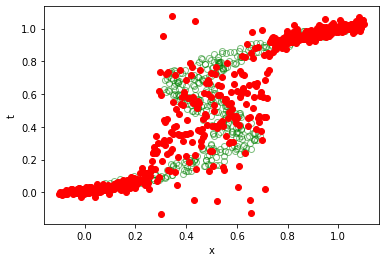

In [54]:
# plot
fig = plt.figure(figsize=(6, 4))
plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, samples.squeeze().detach(), 'ro', linewidth=3.0)
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data_prob_std_fit.png", dpi=200)
plt.show()

# Mixture Density Networks

<img src="./figures/architecture.png" alt="drawing" width="600"/>

The loss is now the probability under this mixture of Gaussians  <br/>

$L = -\sum_i \log p(t_i) = -\sum_i \log \sum_j \alpha_{j,i} N(t_i; \mu_{j,i}, \sigma_{j,i})$  <br/>

We learn the mixture components $\alpha_j$, the means $\mu_j$, and the variances $\sigma_j$.

In [55]:
class MultivariateGaussianMDN(nn.Module):
    """
    For a documented version of this code, see: 
    https://github.com/mackelab/pyknos/blob/main/pyknos/mdn/mdn.py
    """

    def __init__(
        self,
        features,
        hidden_net,
        num_components,
        hidden_features,
    ):

        super().__init__()

        self._features = features
        self._num_components = num_components
        
        self._hidden_net = hidden_net
        self._logits_layer = nn.Linear(hidden_features, num_components)
        self._means_layer = nn.Linear(hidden_features, num_components * features)
        self._unconstrained_diagonal_layer = nn.Linear(
            hidden_features, num_components * features
        )

    def get_mixture_components(
        self, context
    ):
        h = self._hidden_net(context)

        logits = self._logits_layer(h)
        logits = logits - torch.logsumexp(logits, dim=1).unsqueeze(1)
        means = self._means_layer(h).view(-1, self._num_components, self._features)

        log_variances = self._unconstrained_diagonal_layer(h).view(
            -1, self._num_components, self._features
        )
        variances = torch.exp(log_variances)

        return logits, means, variances

def mog_log_prob(theta, logits, means, variances):

    _, _, theta_dim = means.size()
    theta = theta.view(-1, 1, theta_dim)

    log_cov_det = -0.5*torch.log(torch.prod(variances, dim=2))

    a = logits
    b = -(theta_dim / 2.0) * log(2 * pi)
    c = log_cov_det
    d1 = theta.expand_as(means) - means
    precisions = 1.0 / variances
    exponent = torch.sum(d1 * precisions * d1, dim=2)
    exponent = tensor(-0.5) * exponent

    return torch.logsumexp(a + b + c + exponent, dim=-1)

def mog_sample(logits, means, variances):

    coefficients = F.softmax(logits, dim=-1)

    choices = torch.multinomial(
        coefficients, num_samples=1, replacement=True
    ).view(-1)

    # Select first batch-position.
    chosen_means = means[0, choices, :]
    chosen_variances = variances[0, choices, :]

    _, _, output_dim = means.shape
    standard_normal_samples = torch.randn(output_dim, 1)
    zero_mean_samples = standard_normal_samples * torch.sqrt(chosen_variances)
    samples = chosen_means + zero_mean_samples

    return samples

In [60]:
dataset = data.TensorDataset(x, theta)
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    features=1,
    hidden_net=nn.Sequential(
        nn.Linear(1, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
    ),
    num_components=5,
    hidden_features=30,
)
opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(200):
    for x_batch, theta_batch in train_loader:
        opt.zero_grad()
        logits, means, variances = mdn.get_mixture_components(x_batch)
        out = mog_log_prob(theta_batch, logits, means, variances)
        loss = -out.sum()
        loss.backward()
        opt.step()

In [64]:
samples = []
x_test = torch.linspace(-0.1, 1.1, 500).unsqueeze(1)

for single_x in x_test:
    logits, means, variances = mdn.get_mixture_components(single_x.unsqueeze(1))
    sample = mog_sample(logits, means, variances)
    
    samples.append(sample)
samples = torch.cat(samples).data

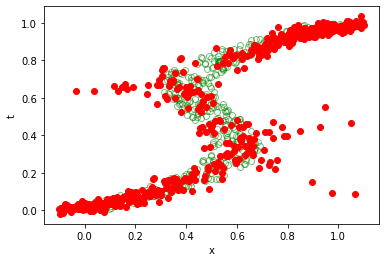

In [65]:
fig = plt.figure(figsize=(6, 4))
plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, samples.squeeze().detach(), 'ro', linewidth=3.0)
plt.xlabel('x')
plt.ylabel('t')
# plt.savefig("data_prob_std_fit.png", dpi=200)
plt.show()

## Summary: mixture density networks

<br/>
- Mixture density networks predict parameters of a mixture of Gaussians <br/>
<br/>
- Because of this, this can capture variability and multi-modality <br/>
<br/>
- To look at their predictions, one can either draw samples from the predicted mixture of Gaussians or evaluate the probability of the prediction

# What are the limitations?
<br/>
- One has to decide on hyperparameters: e.g. how many **components** (i.e. Gaussians) will I need? <br/>
<br/>
- Training often does not converge perfectly. <br/>
<br/>
- In practice, high-dimensional distributions might not be captured perfectly even with a high number of components. <br/>

# Acknowledgments
<br/>
<br/>

Parts of the code from: https://mikedusenberry.com/mixture-density-networks  <br/>
Code of MDNs based on Conor Durkan's `lfi` package.  <br/>
Bishop, 1994  <br/>
[MDN graphic](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca)
Pedro Gonçalves et al. for figure.